In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

base_path = r"~/facial_expression_and_network_impairment/data/raw/audio-video/Webrtc_internals_dataset"



In [2]:
def find_property(data, property_prefix, property_suffix):
    value = next(((k, v) for k, v in data.items() if k.startswith(property_prefix) and k.endswith(property_suffix)), None)
    if value is None:
        return None, None
    k, v = value
    v['values'] = json.loads(v['values'])
    
    return k, v

def read_internals(file_path):
    f = open(file_path)
 
    data = json.load(f)
    stats = data['PeerConnections'][next(iter(data['PeerConnections']))]['stats']

    prop, video_packets_lost = find_property(stats,'RTCRemoteInboundRtpVideoStream_','-packetsLost')

    prop, video_jitter = find_property(stats,'RTCRemoteInboundRtpVideoStream_','-jitter')

    prop, audio_packets_lost = find_property(stats,'RTCRemoteInboundRtpAudioStream_','-packetsLost')

    prop, audio_jitter = find_property(stats,'RTCRemoteInboundRtpAudioStream_','-jitter')
    
    return video_packets_lost, video_jitter, audio_packets_lost, audio_jitter


### Read data

In [3]:
users_folders = [f for f in Path(base_path).rglob('User*')]

webrtc_internals = []

for user_folder in users_folders:
    #webrtc_internals = []
    user = user_folder.name
    
    #print(user)
    
    user_files = [f for f in user_folder.rglob('webrtc_internals_dump*')]
    for file in user_files:
        
        data = {}
        parts = file.name.split('-')  
        tc_parts = parts[1].split('_')
        data['user'] = user
        data['tc'] = tc_parts[0]
        data['delay'] = tc_parts[1]
        data['jitter'] = parts[2]
        data['packet_loss'] = parts[3].split('.')[0]
        video_packets_lost, video_jitter, audio_packets_lost, audio_jitter = read_internals(file)
        data['video_packets_lost'] = video_packets_lost
        data['video_jitter'] = video_jitter
        data['audio_packets_lost'] = audio_packets_lost
        data['audio_jitter'] = audio_jitter
        
        if audio_packets_lost is None:
            print('Skipping {}, {}: there is no values on audio_packets_lost'.format(user, data['tc']))
            continue
        
        len_itens = len(audio_packets_lost['values'])
        if len_itens < 120:
            print('Skipping {}, {}: it contains {} values on audio_packets_lost'.format(user, data['tc'], len_itens))
            continue
        
        len_itens = len(video_packets_lost['values'])
        if len_itens < 120:
            print('Skipping {}, {}: it contains {} values on video_packets_lost'.format(user, data['tc'], len_itens))
            continue
            
        #packet lost is incremental - calculating each second loss
        video_packets_lost_processed = {}
        video_packets_lost_processed['values'] = []
        for i in range(len_itens):
            if i == 0:
                video_packets_lost_processed['values'].append(video_packets_lost['values'][i])
            else:
                video_packets_lost_processed['values'].append(video_packets_lost['values'][i]-video_packets_lost['values'][i-1])
        data['video_packets_lost_processed'] = video_packets_lost_processed
        
        
        audio_packets_lost_processed = {}
        audio_packets_lost_processed['values'] = []
        for i in range(len(audio_packets_lost['values'])):
            if i == 0:
                audio_packets_lost_processed['values'].append(audio_packets_lost['values'][i])
            else:
                audio_packets_lost_processed['values'].append(audio_packets_lost['values'][i]-audio_packets_lost['values'][i-1])
        data['audio_packets_lost_processed'] = audio_packets_lost_processed
        
        webrtc_internals.append(data)
    
    #plot_data('TC11', 'video_packets_lost')
        
        
        
        

Skipping User15, TC15: there is no values on audio_packets_lost
Skipping User6, TC10: it contains 114 values on audio_packets_lost
Skipping User6, TC12: it contains 112 values on audio_packets_lost
Skipping User6, TC13: it contains 109 values on audio_packets_lost
Skipping User10, TC2: it contains 4 values on audio_packets_lost
Skipping User16, TC15: it contains 116 values on audio_packets_lost
Skipping User16, TC12: it contains 111 values on audio_packets_lost
Skipping User18, TC8: there is no values on audio_packets_lost


### Plot data

In [27]:
def plot_data(tc,internal, bins=None):
    # Filter data for tc equals TC11
    tc11_data = [item for item in webrtc_internals if item['tc'] == tc]
    #print(tc11_data)

    # Extract video_packets_lost.values and convert to numpy arrays
    packets_lost_values = []
    for item in tc11_data:
        values = item[internal]['values']
        
        if bins is not None:
            values = np.digitize(values, bins=bins)
        
        # getting first 2 minutes
        packets_lost_values.append(values[:120])
        #print(len(values[:120]))

        
    # Convert list of lists to a numpy array
    packets_lost_values = np.array(packets_lost_values)

    # Calculate mean and standard deviation along the columns (axis=0)
    
    mean_values = np.mean(packets_lost_values, axis=0)
    std_values = np.std(packets_lost_values, axis=0)

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.errorbar(range(len(mean_values)), mean_values, yerr=std_values, fmt='-o', capsize=5)
    plt.title('Mean and Standard Deviation of {} ({})'.format(internal, tc))
    plt.xlabel('Index')
    plt.ylabel(internal)
    plt.grid(True)
    plt.savefig('img/internals_{}_{}.png'.format(internal, tc))
    plt.show()
    
def plot_all_data(tc):
    #plot_data(tc, 'video_packets_lost')
    #plot_data(tc, 'video_packets_lost_processed')
    plot_data(tc, 'video_jitter')
    #plot_data(tc, 'audio_packets_lost')
    #plot_data(tc, 'audio_packets_lost_processed')
    plot_data(tc, 'audio_jitter')

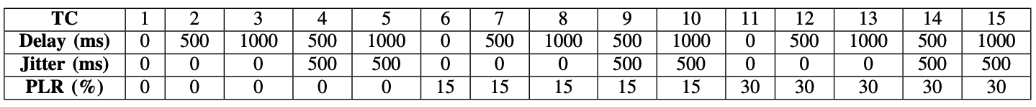

In [28]:
from IPython.display import Image
Image("img/TCs.png")

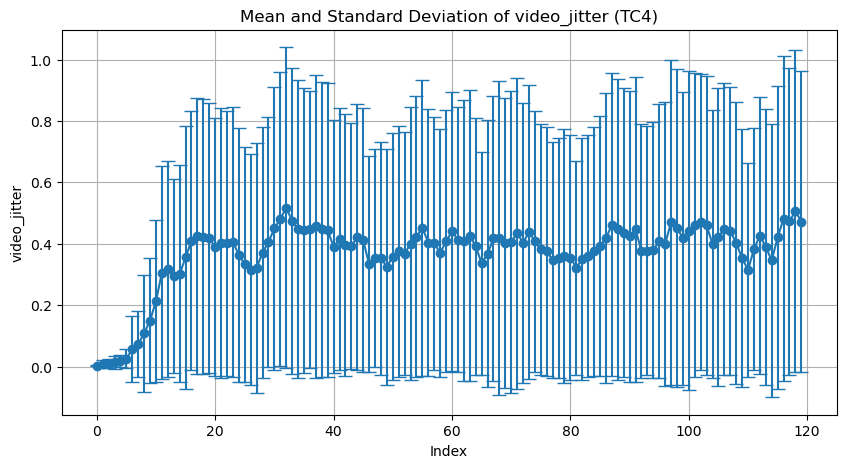

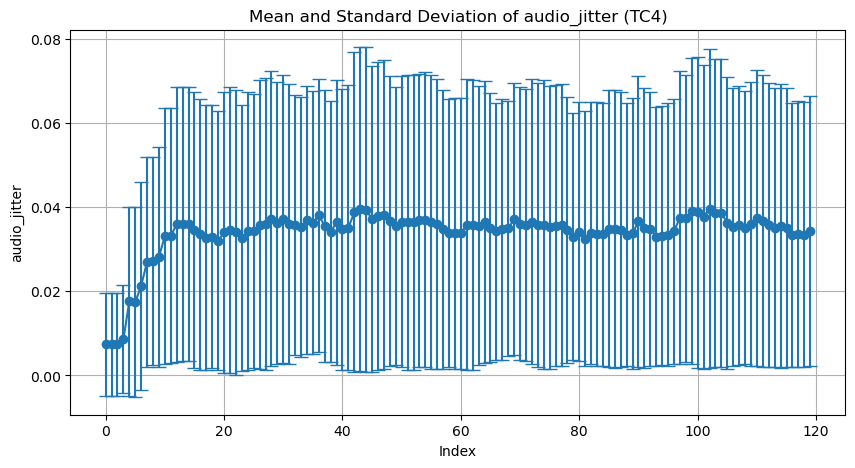

In [37]:
plot_all_data('TC4')

In [7]:
max_video_packets_lost = 0
max_video_packets_lost_processed = 0
max_video_jitter = 0
max_audio_packets_lost = 0
max_audio_packets_lost_processed = 0
max_audio_jitter = 0

for t in webrtc_internals:
    max_video_packets_lost = max(max_video_packets_lost, max(t['video_packets_lost']['values']))
    max_video_packets_lost_processed = max(max_video_packets_lost,max(t['video_packets_lost_processed']['values']))
    max_video_jitter = max(max_video_jitter,max(t['video_jitter']['values']))
    max_audio_packets_lost = max(max_audio_packets_lost, max(t['audio_packets_lost']['values']))
    max_audio_packets_lost_processed = max(max_audio_packets_lost,max(t['audio_packets_lost_processed']['values']))
    max_audio_jitter = max(max_audio_jitter,max(t['audio_jitter']['values']))
    
    
print('max_video_packets_lost', max_video_packets_lost)
print('max_video_packets_lost_processed', max_video_packets_lost_processed)
print('max_video_jitter', max_video_jitter)
print('max_audio_packets_lost', max_audio_packets_lost)
print('max_audio_packets_lost_processed', max_audio_packets_lost_processed)
print('max_audio_jitter', max_audio_jitter)


max_video_packets_lost 2616
max_video_packets_lost_processed 2616
max_video_jitter 1.7621
max_audio_packets_lost 1967
max_audio_packets_lost_processed 1967
max_audio_jitter 0.1376875


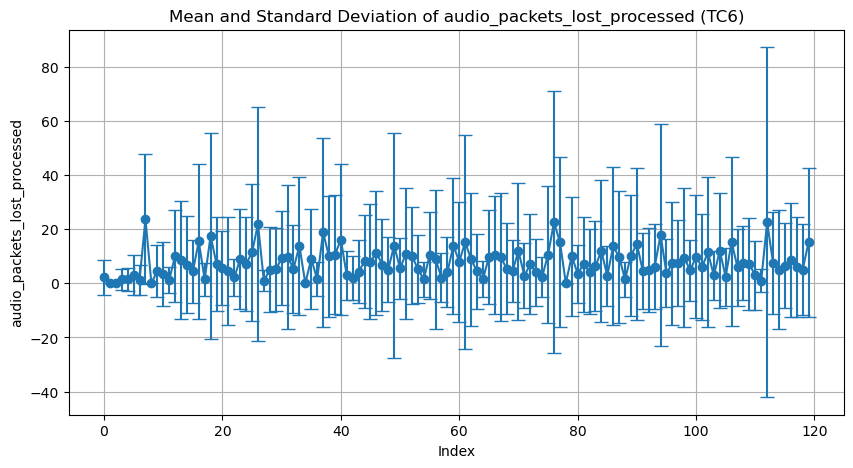

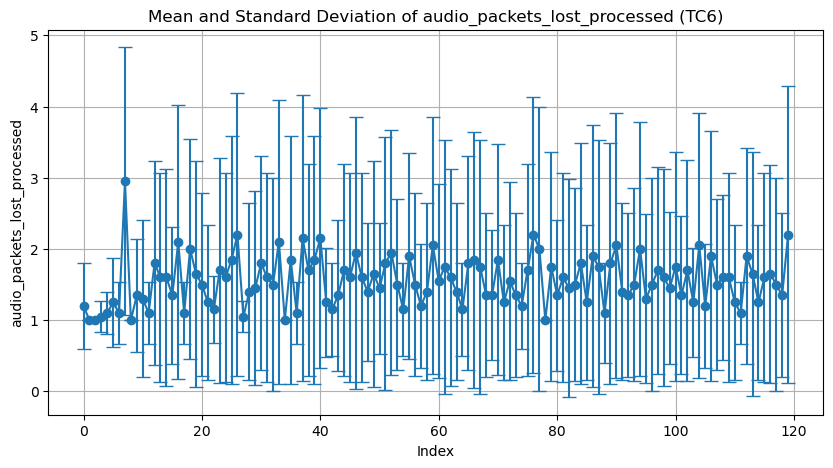

In [8]:
plot_data('TC6', 'audio_packets_lost_processed')
plot_data('TC6', 'audio_packets_lost_processed', [0,10, 20, 30, 40, 50])

# Working with Openface data

In [9]:
import os
import pandas as pd
import numpy as np
import re

data_root = r"/Users/eduardo.lpereira/workspace/MAC6958/transformer-webrtc-2024"
num_lines = 3600

In [10]:
files = [f for f in Path(data_root, 'data/raw/Facial_expression_features_dataset').rglob('TC*.csv')]


In [11]:
def read_user_tc(f):
    user = str(f).split('/')[-2]
    from_name= re.split('[_\-.]', f.name)[:-1]
    return user, from_name[0]

# Initialize lists to hold the data and targets
data_sequences = []
target_sequences = []

tc_11_target_sequences = []
tc_5_target_sequences = []

# Process each file
for file_path in files:
    
    user, tc = read_user_tc(file_path)
    
    #if user != 'User1' or tc != 'TC11':
    #if tc != 'TC1' and tc != 'TC6' and tc != 'TC11':
        #print('Skip {}'.format(tc))
        #continue

    # Read the first 3600 lines of the file
    df = pd.read_csv(file_path, nrows=num_lines)
    
    if len(df) < 3600:
        print('Skipping {}, {} invalid face features data, len {}'.format(user,tc,len(df)))
        continue
        
    data_internals = [item for item in webrtc_internals if item['user'] == user and item['tc'] == tc]
    
    if len(data_internals) == 0:
        print('Skipping {}, {} no Internals'.format(user,tc))
        continue
        
    video_packets_lost = data_internals[0]['video_packets_lost_processed']['values']
    video_jitter = data_internals[0]['video_jitter']['values']
    audio_packets_lost = data_internals[0]['audio_packets_lost_processed']['values']
    audio_jitter = data_internals[0]['audio_jitter']['values']
    
    #categorizing target
    #video_packets_lost = np.digitize(video_packets_lost, bins=[0,10, 20, 30, 40, 50])
    #audio_packets_lost = np.digitize(audio_packets_lost, bins=[0,5,10,15, 20,25, 30, 40, 50])/10
    #video_jitter = np.digitize(video_jitter, bins=[0,0.25,0.5,0.75,1])
    #audio_jitter = np.digitize(audio_jitter, bins=[0,0.025,0.05,0.075,0.1])

    # Reshape the data into sequences of 30 frames
    
    time_window = 10
    frames = 30
    
    for time_idx in range(120-time_window):
        #print('time_idx', time_idx)
            
        sequence = []
        for j in range(time_window):
            # Extract the sequence of 30 frames
            # Select only the feature columns (starting from the 4th column)
            frame_idx = (time_idx + j)  * frames
            
            #print('frame_idx', frame_idx)

            d = df.iloc[frame_idx:frame_idx+1, 5:].to_numpy()
            #print(d)
            sequence.append(d[0])

        if len(sequence) != time_window:
            print('Invalid sequence')
            continue
        data_sequences.append(sequence)

        target = [np.mean(video_packets_lost[time_idx:time_idx+time_window]), np.mean(audio_packets_lost[time_idx:time_idx+time_window]), np.mean(video_jitter[time_idx:time_idx+time_window]) , np.mean(audio_jitter[time_idx:time_idx+time_window])]


        #target = 0;
        #if tc == 'TC6':
        #    target = 1
        #if tc == 'TC11':
        #    target = 2

        if len(target) != 4:
            print('Invalid target')
            continue


        target_sequences.append(target)

        if tc == 'TC5':
            tc_5_target_sequences.append(target)

        if tc == 'TC11':
            tc_11_target_sequences.append(target)

# Convert lists to numpy arrays


X = np.array(data_sequences)
y = np.array(target_sequences)

y_tc5 = np.array(tc_5_target_sequences)
y_tc11 = np.array(tc_11_target_sequences)

# Verify the shapes
print('\n')
print(f'Input data shape: {X.shape}')
print(f'Target data shape: {y.shape}')

Skipping User5, TC9 invalid face features data, len 1811
Skipping User5, TC14 invalid face features data, len 1811
Skipping User5, TC3 invalid face features data, len 1811
Skipping User5, TC7 invalid face features data, len 1811
Skipping User5, TC4 invalid face features data, len 1812
Skipping User5, TC1 invalid face features data, len 1811
Skipping User5, TC5 invalid face features data, len 1811
Skipping User5, TC13 invalid face features data, len 1811
Skipping User5, TC2 invalid face features data, len 1811
Skipping User5, TC11 invalid face features data, len 1811
Skipping User5, TC10 invalid face features data, len 1812
Skipping User5, TC15 invalid face features data, len 1811
Skipping User5, TC6 invalid face features data, len 1812
Skipping User5, TC8 invalid face features data, len 1811
Skipping User5, TC12 invalid face features data, len 428
Skipping User3, TC15 invalid face features data, len 1127
Skipping User14, TC9 invalid face features data, len 722
Skipping User12, TC14 inv

In [12]:
import pandas as pd

# Reading a CSV file
df = pd.read_csv('/Users/eduardo.lpereira/workspace/MAC6958/transformer-webrtc-2024/data/raw/Facial_expression_features_dataset/User1/TC11_0-0-30.csv')

#selected_columns = df['confidence', 'success', 'gaze_0_x', 'gaze_0_y', 'gaze_0_z', 'gaze_1_x', 'gaze_1_y', 'gaze_1_z', 'gaze_angle_x', 'gaze_angle_y']

#selected_columns = df['confidence']

# Display the first few rows of the DataFrame
print(df.head())

start = 6


#print(df.iloc[:, [3,5, 6, 7, 8 ,9, 10, 11, 12]].iloc[start:start+1])

   frame   face_id   timestamp   confidence   success   gaze_0_x   gaze_0_y  \
0      1         0       0.000         0.98         1   0.034683   0.259237   
1      2         0       0.033         0.98         1   0.041332   0.254002   
2      3         0       0.067         0.98         1   0.039589   0.258474   
3      4         0       0.100         0.98         1   0.043594   0.255699   
4      5         0       0.133         0.98         1   0.032679   0.255633   

    gaze_0_z   gaze_1_x   gaze_1_y  ...   AU12_c   AU14_c   AU15_c   AU17_c  \
0  -0.965191  -0.238216   0.239092  ...      0.0      1.0      0.0      0.0   
1  -0.966320  -0.240105   0.228941  ...      0.0      1.0      0.0      0.0   
2  -0.965207  -0.233013   0.234943  ...      0.0      1.0      0.0      0.0   
3  -0.965773  -0.233250   0.238932  ...      0.0      1.0      0.0      0.0   
4  -0.966221  -0.223288   0.243376  ...      0.0      1.0      0.0      0.0   

    AU20_c   AU23_c   AU25_c   AU26_c   AU28_c   A

In [13]:
#X[1]
#y

# Training

### Data preparation

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, LSTM, Flatten, GRU, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [15]:
# encode categories

def encode_into_bins(array, bin_def_array):
    number_of_bins = 6
    
    # Discretize each feature into bins
    # 6 bins require 7 edges
    bins = np.linspace(np.min(bin_def_array), np.max(bin_def_array), number_of_bins+1)  
    #print('bins: {}'.format(bins))
    
    # `np.digitize` returns bin index; subtract 1 for zero-based labels
    encoded = np.digitize(array, bins) - 1
    
    #ensure labels
    encoded[encoded == number_of_bins] = (number_of_bins -1)
    encoded[encoded == -1] = 0
    
    return encoded


video_packets_loss_encoded = encode_into_bins(y[:, 0], y_tc11[:, 0])
audio_packets_loss_encoded = encode_into_bins(y[:, 1], y_tc11[:, 1])
video_jitter_encoded = encode_into_bins(y[:, 2], y_tc5[:, 2])
audio_jitter_encoded = encode_into_bins(y[:, 3], y_tc5[:, 3])

# Combine the encoded values
y_2 = np.stack((video_packets_loss_encoded, audio_packets_loss_encoded, video_jitter_encoded, audio_jitter_encoded), axis=1)

for i in range(0,4):
    print(i,set(y_2[:,i]))

0 {0, 1, 2, 3, 4, 5}
1 {0, 1, 2, 3, 4, 5}
2 {0, 1, 2, 3, 4, 5}
3 {0, 1, 2, 3, 4, 5}


In [16]:
from collections import Counter

counts = Counter(video_packets_loss_encoded)
print('video_packets_loss_encoded: {}'.format(counts))

counts = Counter(audio_packets_loss_encoded)
print('audio_packets_loss_encoded: {}'.format(counts))

counts = Counter(video_jitter_encoded)
print('video_jitter_encoded: {}'.format(counts))

counts = Counter(audio_jitter_encoded)
print('audio_jitter_encoded: {}'.format(counts))

video_packets_loss_encoded: Counter({0: 23728, 1: 4729, 2: 587, 3: 237, 4: 117, 5: 82})
audio_packets_loss_encoded: Counter({0: 14319, 1: 8911, 2: 3931, 3: 1696, 4: 409, 5: 214})
video_jitter_encoded: Counter({0: 20395, 3: 3967, 4: 2933, 2: 1363, 1: 553, 5: 269})
audio_jitter_encoded: Counter({0: 19548, 4: 4787, 5: 3584, 3: 1190, 1: 190, 2: 181})


In [17]:
# If `y` is not already in integer format, convert it.
# Example: if `y` contains continuous values, you might need to bin them into classes
#y_2 = np.digitize(y, bins=[0.1, 0.2, 0.3, 0.4])
#y_2 = y.astype('int64')

#y_2 = to_categorical(y, num_classes=3)

#scaler_y = StandardScaler()
#y_2 = scaler_y.fit_transform(y.reshape(-1, y.shape[-1])).reshape(y.shape)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_2, test_size=0.2, random_state=42)

# Standardize the input data
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
#X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Check the shapes
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (23584, 10, 323)
X_test shape: (5896, 10, 323)
y_train shape: (23584, 4)
y_test shape: (5896, 4)


### Build the Model

In [18]:
def append_history(history, new_history):
    for key in history.history.keys():
        history.history[key].extend(new_history.history[key])

In [56]:

# Define the input layer
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))  # Replace input_dim with your input dimension

gru_1 = GRU(128, return_sequences=True)(input_layer)
batch_1 = BatchNormalization()(gru_1)
gru_2 = GRU(64, return_sequences=False)(batch_1)
batch_2 = BatchNormalization()(gru_2)
dense_1 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(batch_2)
drop_1 = tf.keras.layers.Dropout(0.2)(dense_1)
dense_2 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(drop_1)
drop_2 = tf.keras.layers.Dropout(0.2)(dense_2)
hidden_layer = drop_2

# Define separate output layers for each feature
output_video_packets_loss = Dense(6, activation='softmax', name='video_packets_loss_output')(hidden_layer)  # 6 categories
output_audio_packets_loss = Dense(6, activation='softmax', name='audio_packets_loss_output')(hidden_layer)  # 6 categories
output_video_jitter = Dense(6, activation='softmax', name='video_jitter_output')(hidden_layer)  # 6 categories
output_audio_jitter = Dense(6, activation='softmax', name='audio_jitter_output')(hidden_layer)  # 6 categories

# Define the model with multiple outputs
model = Model(inputs=input_layer, outputs=[output_video_packets_loss, output_audio_packets_loss, output_video_jitter, output_audio_jitter])

# Compile the model
model.compile(optimizer='adam',
                  loss={'video_packets_loss_output': 'SparseCategoricalCrossentropy',
                        'audio_packets_loss_output': 'SparseCategoricalCrossentropy',
                        'video_jitter_output': 'SparseCategoricalCrossentropy',
                        'audio_jitter_output': 'SparseCategoricalCrossentropy'},
                  metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 10, 323)]            0         []                            
                                                                                                  
 gru_2 (GRU)                 (None, 10, 128)              173952    ['input_2[0][0]']             
                                                                                                  
 batch_normalization_2 (Bat  (None, 10, 128)              512       ['gru_2[0][0]']               
 chNormalization)                                                                                 
                                                                                                  
 gru_3 (GRU)                 (None, 64)                   37248     ['batch_normalization_2[

In [57]:
def combine_histories(history_list):
    combined_history = {}
    for history in history_list:
        for key, values in history.history.items():
            if key not in combined_history:
                combined_history[key] = values
            else:
                combined_history[key].extend(values)
    return combined_history

history_list = []

for i in range(100):
    print('\n\n ***** TRAINING {}'.format(i))
    history = model.fit(X_train, [y_train[:,0], y_train[:,1], y_train[:,2], y_train[:,3]],
          epochs = 10,
          batch_size=32,
          validation_data = (X_test, [y_test[:,0], y_test[:,1], y_test[:,2], y_test[:,3]])
        )
    history_list.append(history)



 ***** TRAINING 0
Epoch 1/10
737/737 [==============================] - 10s 11ms/step - loss: 4.5459 - video_packets_loss_output_loss: 0.7069 - audio_packets_loss_output_loss: 1.3362 - video_jitter_output_loss: 0.9540 - audio_jitter_output_loss: 1.0688 - video_packets_loss_output_accuracy: 0.7916 - audio_packets_loss_output_accuracy: 0.4401 - video_jitter_output_accuracy: 0.6770 - audio_jitter_output_accuracy: 0.6440 - val_loss: 3.7838 - val_video_packets_loss_output_loss: 0.6051 - val_audio_packets_loss_output_loss: 1.2114 - val_video_jitter_output_loss: 0.7589 - val_audio_jitter_output_loss: 0.9212 - val_video_packets_loss_output_accuracy: 0.8077 - val_audio_packets_loss_output_accuracy: 0.4917 - val_video_jitter_output_accuracy: 0.7164 - val_audio_jitter_output_accuracy: 0.6764
Epoch 2/10
737/737 [==============================] - 10s 13ms/step - loss: 3.6597 - video_packets_loss_output_loss: 0.5946 - audio_packets_loss_output_loss: 1.2073 - video_jitter_output_loss: 0.7499 - audi

Epoch 2/10
737/737 [==============================] - 8s 11ms/step - loss: 2.3507 - video_packets_loss_output_loss: 0.3912 - audio_packets_loss_output_loss: 0.9247 - video_jitter_output_loss: 0.4688 - audio_jitter_output_loss: 0.4959 - video_packets_loss_output_accuracy: 0.8595 - audio_packets_loss_output_accuracy: 0.6211 - video_jitter_output_accuracy: 0.8072 - audio_jitter_output_accuracy: 0.8092 - val_loss: 2.2876 - val_video_packets_loss_output_loss: 0.3779 - val_audio_packets_loss_output_loss: 0.9264 - val_video_jitter_output_loss: 0.4442 - val_audio_jitter_output_loss: 0.4687 - val_video_packets_loss_output_accuracy: 0.8655 - val_audio_packets_loss_output_accuracy: 0.6135 - val_video_jitter_output_accuracy: 0.8200 - val_audio_jitter_output_accuracy: 0.8155
Epoch 3/10
737/737 [==============================] - 8s 10ms/step - loss: 2.2983 - video_packets_loss_output_loss: 0.3773 - audio_packets_loss_output_loss: 0.9131 - video_jitter_output_loss: 0.4630 - audio_jitter_output_loss: 

Epoch 3/10
737/737 [==============================] - 9s 12ms/step - loss: 2.0191 - video_packets_loss_output_loss: 0.3050 - audio_packets_loss_output_loss: 0.8255 - video_jitter_output_loss: 0.4113 - audio_jitter_output_loss: 0.4049 - video_packets_loss_output_accuracy: 0.8880 - audio_packets_loss_output_accuracy: 0.6642 - video_jitter_output_accuracy: 0.8276 - audio_jitter_output_accuracy: 0.8393 - val_loss: 2.0831 - val_video_packets_loss_output_loss: 0.3383 - val_audio_packets_loss_output_loss: 0.8436 - val_video_jitter_output_loss: 0.3981 - val_audio_jitter_output_loss: 0.4318 - val_video_packets_loss_output_accuracy: 0.8809 - val_audio_packets_loss_output_accuracy: 0.6543 - val_video_jitter_output_accuracy: 0.8360 - val_audio_jitter_output_accuracy: 0.8358
Epoch 4/10
737/737 [==============================] - 8s 11ms/step - loss: 1.9845 - video_packets_loss_output_loss: 0.2952 - audio_packets_loss_output_loss: 0.8210 - video_jitter_output_loss: 0.3971 - audio_jitter_output_loss: 

Epoch 4/10
737/737 [==============================] - 8s 10ms/step - loss: 1.8276 - video_packets_loss_output_loss: 0.2624 - audio_packets_loss_output_loss: 0.7653 - video_jitter_output_loss: 0.3644 - audio_jitter_output_loss: 0.3634 - video_packets_loss_output_accuracy: 0.9020 - audio_packets_loss_output_accuracy: 0.6928 - video_jitter_output_accuracy: 0.8453 - audio_jitter_output_accuracy: 0.8532 - val_loss: 1.8359 - val_video_packets_loss_output_loss: 0.2697 - val_audio_packets_loss_output_loss: 0.7909 - val_video_jitter_output_loss: 0.3584 - val_audio_jitter_output_loss: 0.3464 - val_video_packets_loss_output_accuracy: 0.9004 - val_audio_packets_loss_output_accuracy: 0.6833 - val_video_jitter_output_accuracy: 0.8485 - val_audio_jitter_output_accuracy: 0.8584
Epoch 5/10
737/737 [==============================] - 8s 11ms/step - loss: 1.8367 - video_packets_loss_output_loss: 0.2603 - audio_packets_loss_output_loss: 0.7703 - video_jitter_output_loss: 0.3673 - audio_jitter_output_loss: 

Epoch 5/10
737/737 [==============================] - 8s 10ms/step - loss: 1.7364 - video_packets_loss_output_loss: 0.2416 - audio_packets_loss_output_loss: 0.7345 - video_jitter_output_loss: 0.3415 - audio_jitter_output_loss: 0.3466 - video_packets_loss_output_accuracy: 0.9085 - audio_packets_loss_output_accuracy: 0.7023 - video_jitter_output_accuracy: 0.8537 - audio_jitter_output_accuracy: 0.8610 - val_loss: 1.7553 - val_video_packets_loss_output_loss: 0.2579 - val_audio_packets_loss_output_loss: 0.7684 - val_video_jitter_output_loss: 0.3377 - val_audio_jitter_output_loss: 0.3199 - val_video_packets_loss_output_accuracy: 0.9026 - val_audio_packets_loss_output_accuracy: 0.6923 - val_video_jitter_output_accuracy: 0.8530 - val_audio_jitter_output_accuracy: 0.8703
Epoch 6/10
737/737 [==============================] - 8s 11ms/step - loss: 1.7319 - video_packets_loss_output_loss: 0.2417 - audio_packets_loss_output_loss: 0.7333 - video_jitter_output_loss: 0.3479 - audio_jitter_output_loss: 

Epoch 6/10
737/737 [==============================] - 8s 10ms/step - loss: 1.6616 - video_packets_loss_output_loss: 0.2302 - audio_packets_loss_output_loss: 0.7092 - video_jitter_output_loss: 0.3288 - audio_jitter_output_loss: 0.3234 - video_packets_loss_output_accuracy: 0.9171 - audio_packets_loss_output_accuracy: 0.7169 - video_jitter_output_accuracy: 0.8591 - audio_jitter_output_accuracy: 0.8690 - val_loss: 1.6710 - val_video_packets_loss_output_loss: 0.2362 - val_audio_packets_loss_output_loss: 0.7377 - val_video_jitter_output_loss: 0.3186 - val_audio_jitter_output_loss: 0.3087 - val_video_packets_loss_output_accuracy: 0.9140 - val_audio_packets_loss_output_accuracy: 0.7047 - val_video_jitter_output_accuracy: 0.8653 - val_audio_jitter_output_accuracy: 0.8779
Epoch 7/10
737/737 [==============================] - 8s 10ms/step - loss: 1.6493 - video_packets_loss_output_loss: 0.2269 - audio_packets_loss_output_loss: 0.7054 - video_jitter_output_loss: 0.3290 - audio_jitter_output_loss: 

Epoch 7/10
737/737 [==============================] - 8s 11ms/step - loss: 1.5923 - video_packets_loss_output_loss: 0.2165 - audio_packets_loss_output_loss: 0.6817 - video_jitter_output_loss: 0.3146 - audio_jitter_output_loss: 0.3085 - video_packets_loss_output_accuracy: 0.9212 - audio_packets_loss_output_accuracy: 0.7282 - video_jitter_output_accuracy: 0.8639 - audio_jitter_output_accuracy: 0.8753 - val_loss: 1.7198 - val_video_packets_loss_output_loss: 0.2676 - val_audio_packets_loss_output_loss: 0.7446 - val_video_jitter_output_loss: 0.3142 - val_audio_jitter_output_loss: 0.3229 - val_video_packets_loss_output_accuracy: 0.9049 - val_audio_packets_loss_output_accuracy: 0.7052 - val_video_jitter_output_accuracy: 0.8696 - val_audio_jitter_output_accuracy: 0.8733
Epoch 8/10
737/737 [==============================] - 8s 11ms/step - loss: 1.5806 - video_packets_loss_output_loss: 0.2153 - audio_packets_loss_output_loss: 0.6840 - video_jitter_output_loss: 0.3097 - audio_jitter_output_loss: 

Epoch 8/10
737/737 [==============================] - 8s 11ms/step - loss: 1.5512 - video_packets_loss_output_loss: 0.2071 - audio_packets_loss_output_loss: 0.6792 - video_jitter_output_loss: 0.2973 - audio_jitter_output_loss: 0.2976 - video_packets_loss_output_accuracy: 0.9251 - audio_packets_loss_output_accuracy: 0.7325 - video_jitter_output_accuracy: 0.8758 - audio_jitter_output_accuracy: 0.8803 - val_loss: 1.6491 - val_video_packets_loss_output_loss: 0.2471 - val_audio_packets_loss_output_loss: 0.7195 - val_video_jitter_output_loss: 0.3015 - val_audio_jitter_output_loss: 0.3101 - val_video_packets_loss_output_accuracy: 0.9106 - val_audio_packets_loss_output_accuracy: 0.7191 - val_video_jitter_output_accuracy: 0.8789 - val_audio_jitter_output_accuracy: 0.8753
Epoch 9/10
737/737 [==============================] - 8s 11ms/step - loss: 1.5656 - video_packets_loss_output_loss: 0.2110 - audio_packets_loss_output_loss: 0.6756 - video_jitter_output_loss: 0.3033 - audio_jitter_output_loss: 

Epoch 9/10
737/737 [==============================] - 8s 11ms/step - loss: 1.5430 - video_packets_loss_output_loss: 0.2031 - audio_packets_loss_output_loss: 0.6696 - video_jitter_output_loss: 0.2942 - audio_jitter_output_loss: 0.3061 - video_packets_loss_output_accuracy: 0.9255 - audio_packets_loss_output_accuracy: 0.7402 - video_jitter_output_accuracy: 0.8780 - audio_jitter_output_accuracy: 0.8800 - val_loss: 1.6778 - val_video_packets_loss_output_loss: 0.2445 - val_audio_packets_loss_output_loss: 0.7355 - val_video_jitter_output_loss: 0.3093 - val_audio_jitter_output_loss: 0.3199 - val_video_packets_loss_output_accuracy: 0.9130 - val_audio_packets_loss_output_accuracy: 0.7162 - val_video_jitter_output_accuracy: 0.8703 - val_audio_jitter_output_accuracy: 0.8806
Epoch 10/10
737/737 [==============================] - 8s 11ms/step - loss: 1.5156 - video_packets_loss_output_loss: 0.2007 - audio_packets_loss_output_loss: 0.6637 - video_jitter_output_loss: 0.2919 - audio_jitter_output_loss:

Epoch 10/10
737/737 [==============================] - 8s 11ms/step - loss: 1.4612 - video_packets_loss_output_loss: 0.1936 - audio_packets_loss_output_loss: 0.6465 - video_jitter_output_loss: 0.2764 - audio_jitter_output_loss: 0.2737 - video_packets_loss_output_accuracy: 0.9298 - audio_packets_loss_output_accuracy: 0.7488 - video_jitter_output_accuracy: 0.8856 - audio_jitter_output_accuracy: 0.8906 - val_loss: 1.6252 - val_video_packets_loss_output_loss: 0.2383 - val_audio_packets_loss_output_loss: 0.7215 - val_video_jitter_output_loss: 0.2905 - val_audio_jitter_output_loss: 0.3046 - val_video_packets_loss_output_accuracy: 0.9147 - val_audio_packets_loss_output_accuracy: 0.7229 - val_video_jitter_output_accuracy: 0.8826 - val_audio_jitter_output_accuracy: 0.8864


 ***** TRAINING 10
Epoch 1/10
737/737 [==============================] - 8s 11ms/step - loss: 1.4722 - video_packets_loss_output_loss: 0.1936 - audio_packets_loss_output_loss: 0.6466 - video_jitter_output_loss: 0.2800 - audi



 ***** TRAINING 11
Epoch 1/10
737/737 [==============================] - 8s 10ms/step - loss: 1.4459 - video_packets_loss_output_loss: 0.1866 - audio_packets_loss_output_loss: 0.6403 - video_jitter_output_loss: 0.2703 - audio_jitter_output_loss: 0.2779 - video_packets_loss_output_accuracy: 0.9316 - audio_packets_loss_output_accuracy: 0.7482 - video_jitter_output_accuracy: 0.8892 - audio_jitter_output_accuracy: 0.8889 - val_loss: 1.6370 - val_video_packets_loss_output_loss: 0.2450 - val_audio_packets_loss_output_loss: 0.7434 - val_video_jitter_output_loss: 0.2864 - val_audio_jitter_output_loss: 0.2906 - val_video_packets_loss_output_accuracy: 0.9147 - val_audio_packets_loss_output_accuracy: 0.7151 - val_video_jitter_output_accuracy: 0.8865 - val_audio_jitter_output_accuracy: 0.8855
Epoch 2/10
737/737 [==============================] - 7s 10ms/step - loss: 1.4303 - video_packets_loss_output_loss: 0.1858 - audio_packets_loss_output_loss: 0.6350 - video_jitter_output_loss: 0.2655 - audio

Epoch 2/10
737/737 [==============================] - 8s 11ms/step - loss: 1.4322 - video_packets_loss_output_loss: 0.1908 - audio_packets_loss_output_loss: 0.6322 - video_jitter_output_loss: 0.2663 - audio_jitter_output_loss: 0.2722 - video_packets_loss_output_accuracy: 0.9331 - audio_packets_loss_output_accuracy: 0.7494 - video_jitter_output_accuracy: 0.8936 - audio_jitter_output_accuracy: 0.8912 - val_loss: 1.6174 - val_video_packets_loss_output_loss: 0.2445 - val_audio_packets_loss_output_loss: 0.7398 - val_video_jitter_output_loss: 0.2852 - val_audio_jitter_output_loss: 0.2784 - val_video_packets_loss_output_accuracy: 0.9181 - val_audio_packets_loss_output_accuracy: 0.7203 - val_video_jitter_output_accuracy: 0.8814 - val_audio_jitter_output_accuracy: 0.8877
Epoch 3/10
737/737 [==============================] - 8s 11ms/step - loss: 1.4510 - video_packets_loss_output_loss: 0.1924 - audio_packets_loss_output_loss: 0.6377 - video_jitter_output_loss: 0.2738 - audio_jitter_output_loss: 

Epoch 3/10
737/737 [==============================] - 8s 11ms/step - loss: 1.4458 - video_packets_loss_output_loss: 0.1892 - audio_packets_loss_output_loss: 0.6379 - video_jitter_output_loss: 0.2730 - audio_jitter_output_loss: 0.2759 - video_packets_loss_output_accuracy: 0.9323 - audio_packets_loss_output_accuracy: 0.7487 - video_jitter_output_accuracy: 0.8954 - audio_jitter_output_accuracy: 0.8914 - val_loss: 1.6003 - val_video_packets_loss_output_loss: 0.2294 - val_audio_packets_loss_output_loss: 0.7489 - val_video_jitter_output_loss: 0.2657 - val_audio_jitter_output_loss: 0.2867 - val_video_packets_loss_output_accuracy: 0.9259 - val_audio_packets_loss_output_accuracy: 0.7178 - val_video_jitter_output_accuracy: 0.8964 - val_audio_jitter_output_accuracy: 0.8879
Epoch 4/10
737/737 [==============================] - 8s 11ms/step - loss: 1.4059 - video_packets_loss_output_loss: 0.1807 - audio_packets_loss_output_loss: 0.6263 - video_jitter_output_loss: 0.2592 - audio_jitter_output_loss: 

Epoch 4/10
737/737 [==============================] - 8s 11ms/step - loss: 1.3973 - video_packets_loss_output_loss: 0.1827 - audio_packets_loss_output_loss: 0.6150 - video_jitter_output_loss: 0.2599 - audio_jitter_output_loss: 0.2686 - video_packets_loss_output_accuracy: 0.9331 - audio_packets_loss_output_accuracy: 0.7567 - video_jitter_output_accuracy: 0.8995 - audio_jitter_output_accuracy: 0.8943 - val_loss: 1.5876 - val_video_packets_loss_output_loss: 0.2349 - val_audio_packets_loss_output_loss: 0.7274 - val_video_jitter_output_loss: 0.2673 - val_audio_jitter_output_loss: 0.2876 - val_video_packets_loss_output_accuracy: 0.9194 - val_audio_packets_loss_output_accuracy: 0.7224 - val_video_jitter_output_accuracy: 0.8967 - val_audio_jitter_output_accuracy: 0.8864
Epoch 5/10
737/737 [==============================] - 8s 11ms/step - loss: 1.3965 - video_packets_loss_output_loss: 0.1860 - audio_packets_loss_output_loss: 0.6191 - video_jitter_output_loss: 0.2605 - audio_jitter_output_loss: 

Epoch 5/10
737/737 [==============================] - 8s 11ms/step - loss: 1.3716 - video_packets_loss_output_loss: 0.1835 - audio_packets_loss_output_loss: 0.6118 - video_jitter_output_loss: 0.2515 - audio_jitter_output_loss: 0.2546 - video_packets_loss_output_accuracy: 0.9346 - audio_packets_loss_output_accuracy: 0.7627 - video_jitter_output_accuracy: 0.9029 - audio_jitter_output_accuracy: 0.8957 - val_loss: 1.6223 - val_video_packets_loss_output_loss: 0.2427 - val_audio_packets_loss_output_loss: 0.7505 - val_video_jitter_output_loss: 0.2730 - val_audio_jitter_output_loss: 0.2864 - val_video_packets_loss_output_accuracy: 0.9199 - val_audio_packets_loss_output_accuracy: 0.7235 - val_video_jitter_output_accuracy: 0.8938 - val_audio_jitter_output_accuracy: 0.8938
Epoch 6/10
737/737 [==============================] - 8s 11ms/step - loss: 1.3773 - video_packets_loss_output_loss: 0.1806 - audio_packets_loss_output_loss: 0.6071 - video_jitter_output_loss: 0.2584 - audio_jitter_output_loss: 

Epoch 6/10
737/737 [==============================] - 8s 11ms/step - loss: 1.3772 - video_packets_loss_output_loss: 0.1794 - audio_packets_loss_output_loss: 0.6126 - video_jitter_output_loss: 0.2515 - audio_jitter_output_loss: 0.2630 - video_packets_loss_output_accuracy: 0.9364 - audio_packets_loss_output_accuracy: 0.7611 - video_jitter_output_accuracy: 0.9043 - audio_jitter_output_accuracy: 0.8953 - val_loss: 1.5834 - val_video_packets_loss_output_loss: 0.2269 - val_audio_packets_loss_output_loss: 0.7308 - val_video_jitter_output_loss: 0.2735 - val_audio_jitter_output_loss: 0.2828 - val_video_packets_loss_output_accuracy: 0.9220 - val_audio_packets_loss_output_accuracy: 0.7256 - val_video_jitter_output_accuracy: 0.8974 - val_audio_jitter_output_accuracy: 0.8933
Epoch 7/10
737/737 [==============================] - 8s 11ms/step - loss: 1.3423 - video_packets_loss_output_loss: 0.1772 - audio_packets_loss_output_loss: 0.5989 - video_jitter_output_loss: 0.2410 - audio_jitter_output_loss: 

Epoch 7/10
737/737 [==============================] - 8s 11ms/step - loss: 1.3523 - video_packets_loss_output_loss: 0.1749 - audio_packets_loss_output_loss: 0.5979 - video_jitter_output_loss: 0.2514 - audio_jitter_output_loss: 0.2571 - video_packets_loss_output_accuracy: 0.9375 - audio_packets_loss_output_accuracy: 0.7660 - video_jitter_output_accuracy: 0.9049 - audio_jitter_output_accuracy: 0.8984 - val_loss: 1.5675 - val_video_packets_loss_output_loss: 0.2447 - val_audio_packets_loss_output_loss: 0.7119 - val_video_jitter_output_loss: 0.2669 - val_audio_jitter_output_loss: 0.2732 - val_video_packets_loss_output_accuracy: 0.9235 - val_audio_packets_loss_output_accuracy: 0.7307 - val_video_jitter_output_accuracy: 0.8984 - val_audio_jitter_output_accuracy: 0.8982
Epoch 8/10
737/737 [==============================] - 9s 12ms/step - loss: 1.3416 - video_packets_loss_output_loss: 0.1746 - audio_packets_loss_output_loss: 0.5916 - video_jitter_output_loss: 0.2482 - audio_jitter_output_loss: 

Epoch 8/10
737/737 [==============================] - 8s 11ms/step - loss: 1.3589 - video_packets_loss_output_loss: 0.1852 - audio_packets_loss_output_loss: 0.5986 - video_jitter_output_loss: 0.2418 - audio_jitter_output_loss: 0.2619 - video_packets_loss_output_accuracy: 0.9334 - audio_packets_loss_output_accuracy: 0.7650 - video_jitter_output_accuracy: 0.9080 - audio_jitter_output_accuracy: 0.8976 - val_loss: 1.5254 - val_video_packets_loss_output_loss: 0.2150 - val_audio_packets_loss_output_loss: 0.7200 - val_video_jitter_output_loss: 0.2589 - val_audio_jitter_output_loss: 0.2598 - val_video_packets_loss_output_accuracy: 0.9300 - val_audio_packets_loss_output_accuracy: 0.7283 - val_video_jitter_output_accuracy: 0.9018 - val_audio_jitter_output_accuracy: 0.9011
Epoch 9/10
737/737 [==============================] - 8s 11ms/step - loss: 1.3541 - video_packets_loss_output_loss: 0.1797 - audio_packets_loss_output_loss: 0.6021 - video_jitter_output_loss: 0.2451 - audio_jitter_output_loss: 

Epoch 9/10
737/737 [==============================] - 8s 10ms/step - loss: 1.3192 - video_packets_loss_output_loss: 0.1771 - audio_packets_loss_output_loss: 0.5798 - video_jitter_output_loss: 0.2415 - audio_jitter_output_loss: 0.2481 - video_packets_loss_output_accuracy: 0.9374 - audio_packets_loss_output_accuracy: 0.7718 - video_jitter_output_accuracy: 0.9087 - audio_jitter_output_accuracy: 0.9019 - val_loss: 1.5697 - val_video_packets_loss_output_loss: 0.2476 - val_audio_packets_loss_output_loss: 0.7167 - val_video_jitter_output_loss: 0.2605 - val_audio_jitter_output_loss: 0.2707 - val_video_packets_loss_output_accuracy: 0.9206 - val_audio_packets_loss_output_accuracy: 0.7386 - val_video_jitter_output_accuracy: 0.9013 - val_audio_jitter_output_accuracy: 0.8977
Epoch 10/10
737/737 [==============================] - 8s 10ms/step - loss: 1.2975 - video_packets_loss_output_loss: 0.1735 - audio_packets_loss_output_loss: 0.5754 - video_jitter_output_loss: 0.2329 - audio_jitter_output_loss:

Epoch 10/10
737/737 [==============================] - 8s 11ms/step - loss: 1.2837 - video_packets_loss_output_loss: 0.1652 - audio_packets_loss_output_loss: 0.5731 - video_jitter_output_loss: 0.2333 - audio_jitter_output_loss: 0.2389 - video_packets_loss_output_accuracy: 0.9424 - audio_packets_loss_output_accuracy: 0.7762 - video_jitter_output_accuracy: 0.9118 - audio_jitter_output_accuracy: 0.9042 - val_loss: 1.5810 - val_video_packets_loss_output_loss: 0.2421 - val_audio_packets_loss_output_loss: 0.7274 - val_video_jitter_output_loss: 0.2668 - val_audio_jitter_output_loss: 0.2724 - val_video_packets_loss_output_accuracy: 0.9182 - val_audio_packets_loss_output_accuracy: 0.7283 - val_video_jitter_output_accuracy: 0.8970 - val_audio_jitter_output_accuracy: 0.9006


 ***** TRAINING 21
Epoch 1/10
737/737 [==============================] - 8s 11ms/step - loss: 1.3005 - video_packets_loss_output_loss: 0.1680 - audio_packets_loss_output_loss: 0.5796 - video_jitter_output_loss: 0.2360 - audi



 ***** TRAINING 22
Epoch 1/10
737/737 [==============================] - 8s 11ms/step - loss: 1.2675 - video_packets_loss_output_loss: 0.1661 - audio_packets_loss_output_loss: 0.5695 - video_jitter_output_loss: 0.2239 - audio_jitter_output_loss: 0.2358 - video_packets_loss_output_accuracy: 0.9408 - audio_packets_loss_output_accuracy: 0.7765 - video_jitter_output_accuracy: 0.9152 - audio_jitter_output_accuracy: 0.9048 - val_loss: 1.5530 - val_video_packets_loss_output_loss: 0.2334 - val_audio_packets_loss_output_loss: 0.7163 - val_video_jitter_output_loss: 0.2619 - val_audio_jitter_output_loss: 0.2696 - val_video_packets_loss_output_accuracy: 0.9237 - val_audio_packets_loss_output_accuracy: 0.7346 - val_video_jitter_output_accuracy: 0.9021 - val_audio_jitter_output_accuracy: 0.8993
Epoch 2/10
737/737 [==============================] - 8s 10ms/step - loss: 1.3572 - video_packets_loss_output_loss: 0.1784 - audio_packets_loss_output_loss: 0.5937 - video_jitter_output_loss: 0.2542 - audio

Epoch 2/10
737/737 [==============================] - 8s 10ms/step - loss: 1.2854 - video_packets_loss_output_loss: 0.1726 - audio_packets_loss_output_loss: 0.5802 - video_jitter_output_loss: 0.2230 - audio_jitter_output_loss: 0.2384 - video_packets_loss_output_accuracy: 0.9390 - audio_packets_loss_output_accuracy: 0.7756 - video_jitter_output_accuracy: 0.9168 - audio_jitter_output_accuracy: 0.9059 - val_loss: 1.5524 - val_video_packets_loss_output_loss: 0.2320 - val_audio_packets_loss_output_loss: 0.7087 - val_video_jitter_output_loss: 0.2699 - val_audio_jitter_output_loss: 0.2707 - val_video_packets_loss_output_accuracy: 0.9203 - val_audio_packets_loss_output_accuracy: 0.7315 - val_video_jitter_output_accuracy: 0.8996 - val_audio_jitter_output_accuracy: 0.9033
Epoch 3/10
737/737 [==============================] - 8s 10ms/step - loss: 1.2707 - video_packets_loss_output_loss: 0.1642 - audio_packets_loss_output_loss: 0.5663 - video_jitter_output_loss: 0.2295 - audio_jitter_output_loss: 

Epoch 3/10
737/737 [==============================] - 8s 10ms/step - loss: 1.2665 - video_packets_loss_output_loss: 0.1622 - audio_packets_loss_output_loss: 0.5695 - video_jitter_output_loss: 0.2291 - audio_jitter_output_loss: 0.2329 - video_packets_loss_output_accuracy: 0.9428 - audio_packets_loss_output_accuracy: 0.7757 - video_jitter_output_accuracy: 0.9163 - audio_jitter_output_accuracy: 0.9083 - val_loss: 1.5706 - val_video_packets_loss_output_loss: 0.2491 - val_audio_packets_loss_output_loss: 0.6931 - val_video_jitter_output_loss: 0.2802 - val_audio_jitter_output_loss: 0.2756 - val_video_packets_loss_output_accuracy: 0.9233 - val_audio_packets_loss_output_accuracy: 0.7364 - val_video_jitter_output_accuracy: 0.8979 - val_audio_jitter_output_accuracy: 0.9015
Epoch 4/10
737/737 [==============================] - 8s 10ms/step - loss: 1.2592 - video_packets_loss_output_loss: 0.1623 - audio_packets_loss_output_loss: 0.5657 - video_jitter_output_loss: 0.2248 - audio_jitter_output_loss: 

InvalidArgumentError: Graph execution error:

Detected at node Adam/truediv_15 defined at (most recent call last):
  File "/Users/eduardo.lpereira/anaconda3/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/Users/eduardo.lpereira/anaconda3/lib/python3.10/runpy.py", line 86, in _run_code

  File "/Users/eduardo.lpereira/anaconda3/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/eduardo.lpereira/anaconda3/lib/python3.10/site-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/Users/eduardo.lpereira/anaconda3/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 711, in start

  File "/Users/eduardo.lpereira/anaconda3/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/Users/eduardo.lpereira/anaconda3/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/Users/eduardo.lpereira/anaconda3/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/Users/eduardo.lpereira/anaconda3/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/Users/eduardo.lpereira/anaconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/Users/eduardo.lpereira/anaconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/Users/eduardo.lpereira/anaconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/Users/eduardo.lpereira/anaconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request

  File "/Users/eduardo.lpereira/anaconda3/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 411, in do_execute

  File "/Users/eduardo.lpereira/anaconda3/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 531, in run_cell

  File "/Users/eduardo.lpereira/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell

  File "/Users/eduardo.lpereira/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell

  File "/Users/eduardo.lpereira/anaconda3/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/eduardo.lpereira/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async

  File "/Users/eduardo.lpereira/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes

  File "/Users/eduardo.lpereira/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code

  File "/var/folders/j1/nd9jzc9j1c30zjhj4q6_rfr00000gq/T/ipykernel_422/2640338829.py", line 15, in <module>

  File "/Users/eduardo.lpereira/anaconda3/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/eduardo.lpereira/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1783, in fit

  File "/Users/eduardo.lpereira/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1377, in train_function

  File "/Users/eduardo.lpereira/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1360, in step_function

  File "/Users/eduardo.lpereira/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1349, in run_step

  File "/Users/eduardo.lpereira/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py", line 1130, in train_step

  File "/Users/eduardo.lpereira/anaconda3/lib/python3.10/site-packages/keras/src/optimizers/optimizer.py", line 544, in minimize

  File "/Users/eduardo.lpereira/anaconda3/lib/python3.10/site-packages/keras/src/optimizers/optimizer.py", line 1223, in apply_gradients

  File "/Users/eduardo.lpereira/anaconda3/lib/python3.10/site-packages/keras/src/optimizers/optimizer.py", line 652, in apply_gradients

  File "/Users/eduardo.lpereira/anaconda3/lib/python3.10/site-packages/keras/src/optimizers/optimizer.py", line 1253, in _internal_apply_gradients

  File "/Users/eduardo.lpereira/anaconda3/lib/python3.10/site-packages/keras/src/optimizers/optimizer.py", line 1345, in _distributed_apply_gradients_fn

  File "/Users/eduardo.lpereira/anaconda3/lib/python3.10/site-packages/keras/src/optimizers/optimizer.py", line 1342, in apply_grad_to_update_var

  File "/Users/eduardo.lpereira/anaconda3/lib/python3.10/site-packages/keras/src/optimizers/optimizer.py", line 241, in _update_step

  File "/Users/eduardo.lpereira/anaconda3/lib/python3.10/site-packages/keras/src/optimizers/adam.py", line 204, in update_step

Incompatible shapes: [2,192] vs. [0]
	 [[{{node Adam/truediv_15}}]] [Op:__inference_train_function_7536855]

In [58]:
# Evaluate the model on the validation set
ev  = model.evaluate(X_test, [y_test[:,0], y_test[:,1], y_test[:,2], y_test[:,3]])
print("\n",ev)


185/185 [==============================] - 1s 4ms/step - loss: 1.6117 - video_packets_loss_output_loss: 0.2285 - audio_packets_loss_output_loss: 0.7339 - video_jitter_output_loss: 0.2925 - audio_jitter_output_loss: 0.2830 - video_packets_loss_output_accuracy: 0.9213 - audio_packets_loss_output_accuracy: 0.7261 - video_jitter_output_accuracy: 0.9025 - audio_jitter_output_accuracy: 0.8970

 [1.6116855144500732, 0.22850841283798218, 0.7338722348213196, 0.2924872040748596, 0.2829648554325104, 0.9213025569915771, 0.7260854840278625, 0.9024762511253357, 0.897048830986023]


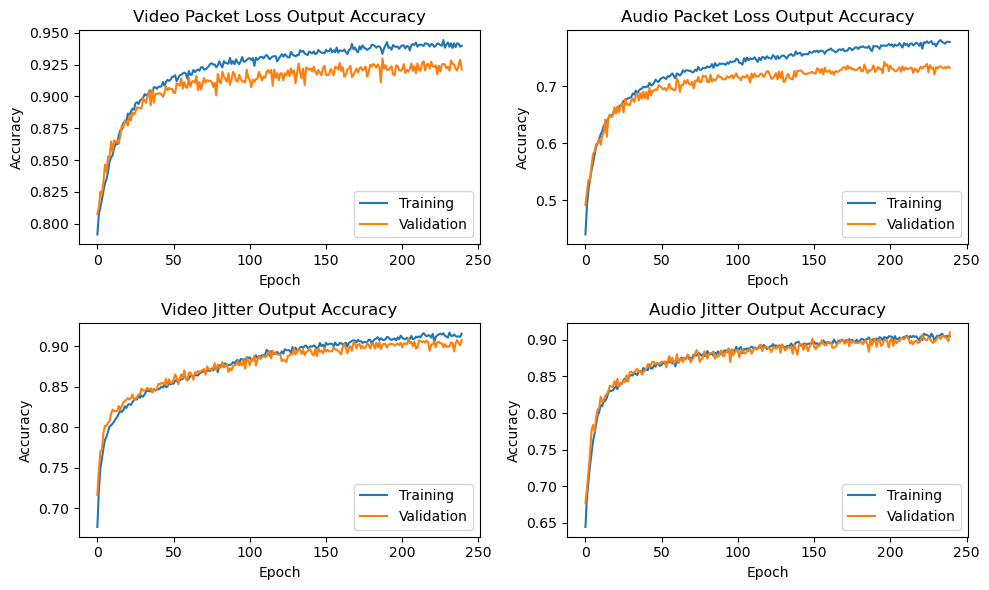

In [64]:
def plot_accuracy(history, print_loss:True):
    
    # Plot training & validation loss values
    #plt.figure(figsize=(10, 5))
    if print_loss:
        plt.plot(history['loss'], label='Training Loss')
        if 'val_loss' in history:
            plt.plot(history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(loc='upper right')
    
    plt.figure(figsize=(10, 6))

    # Plot training & validation loss values
    plt.subplot(2, 2, 1)
    plt.plot(history['video_packets_loss_output_accuracy'], label='Training')
    if 'val_video_packets_loss_output_accuracy' in history:
        plt.plot(history['val_video_packets_loss_output_accuracy'], label='Validation')
    plt.title('Video Packet Loss Output Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Plot training & validation delay_output accuracy values
    plt.subplot(2, 2, 2)
    plt.plot(history['audio_packets_loss_output_accuracy'], label='Training')
    if 'val_audio_packets_loss_output_accuracy' in history:
        plt.plot(history['val_audio_packets_loss_output_accuracy'], label='Validation')
    plt.title('Audio Packet Loss Output Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Plot training & validation jitter_output accuracy values
    plt.subplot(2, 2, 3)
    plt.plot(history['video_jitter_output_accuracy'], label='Training')
    if 'val_video_jitter_output_accuracy' in history:
        plt.plot(history['val_video_jitter_output_accuracy'], label='Validation')
    plt.title('Video Jitter Output Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Plot training & validation packet_loss_output accuracy values
    plt.subplot(2, 2, 4)
    plt.plot(history['audio_jitter_output_accuracy'], label='Training')
    if 'val_audio_jitter_output_accuracy' in history:
        plt.plot(history['val_audio_jitter_output_accuracy'], label='Validation')
    plt.title('Audio Jitter Output Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.savefig('curve-webrtc.png')
    plt.show()
    
plot_accuracy(combine_histories(history_list), False)
#plot_accuracy(history_list[0])

KeyError: 'video_packets_loss_output_accuracy'

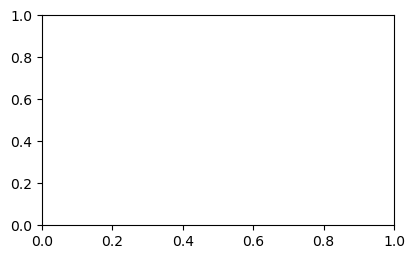

In [61]:
plot_accuracy(combine_histories(history_list[30:]), False)

for k in history_list[0].history.keys():
    history_list[0].history[k] = history_list[0].history[k][:10]

In [63]:
for k in history_list[0].history.keys():
    history_list[0].history[k] = history_list[0].history[k][:10]

In [24]:
history_list = history_list[-10:]

In [25]:
history_list